# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA

from tsne_modifications.dataset_generations.dtsne_datasets import get_dtsne_datasets
from tsne_modifications.metrics.metrics import global_spearman_rank, local_reconstruction_correlation, relative_density_reconstruction
from tsne_modifications.dtsne import DTSNE
from collections import OrderedDict

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# DTSNE Experiments

In this notebook we compare 4 methods for making low-dimensional embeddings with prior knowledge:
* DTSNE
* t-SNE
* MDS
* Isomap
* PCA
* LocallyLinearEmbedding

To generate data, we will use the methods described in the article (https://arxiv.org/pdf/2301.13732.pdf) and below.

### Datasets

<h4> 2D DATA </h4>

We generated two 2-dimensional dataset with 3 Gaussian clusters each. The Gaussian clusters had unit variance and were
centered at (10, 0),(0, 15), and (−10, 0), respectively. For the first dataset, we drew 300 points from each Gaussian and
scaled the spread of the clusters by 1, 2, 4 (i.e., multiply the centered data by this number), respectively. For the second
dataset we drew 100, 200, 500, samples from the Gaussians, respectively, keeping the scale the same across clusters.

 
<h4> G3-S </h4>

For this dataset we generated 3 Gaussian clusters living in 50 dimensions, each cluster distribution ci with mean drawn
from U(0, 50) (each dimension iid from this uniform) and unit variance. We then draw 200, 400, 600 points from c1, c2, c3,
respectively, and scale the spread of the cluster by 2 (i.e., multiply the centered data by 2).

<h4> G3-D </h4>

For this dataset we generated 3 Gaussian clusters living in 50 dimensions, each cluster distribution ci with mean drawn
from U(0, 50) and unit variance. We then draw 300 points from each of the cluster distributions and scale the spread of the
c1, c2, c3 by 2, 4, 8, respectively.

<h4> G10-D </h4>

To look at data that is not easily projectable, i.e., the inter-cluster distances can be correctly modeled in 2D, for this dataset
we generated 10 Gaussian clusters living in 50 dimensions, each cluster distribution ci again with mean drawn from U(0, 50)
and unit variance. We then draw 200 points from each of the cluster distributions and scale the spread of the c1, . . . , c10 by
1, . . . , 10, respectively.

<h4> U5-D </h4>

To look at a different distribution and higher dimensional data, we generated 10 Uniform clusters living in 150 dimensions,
each cluster distribution ci again with mean drawn from U(0, 50) and unit variance. We then draw 200 points from each of
the cluster distributions and scale the spread of the c1, . . . , c10 by 1, . . . , 10, respectively.

<h4> Metric </h4>

We report Spearman rank correlation between all high- and low-dimensional distances ρ
(global reconstruction), correlation between high- and low-dimensional distances of each point with its 100 closest neighbours (local
reconstruction), and correlation between radii of balls enclosing the 100 neighbours of each point in high- and low-dimensional space
(relative density reconstruction).

<h3> Run Experiment </h3>

  0%|          | 0/6 [00:00<?, ?it/s]

2D_1


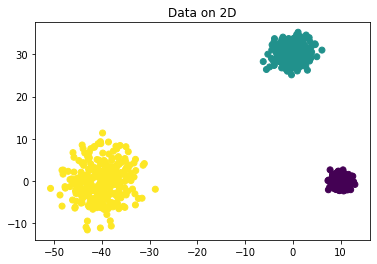

2D_1


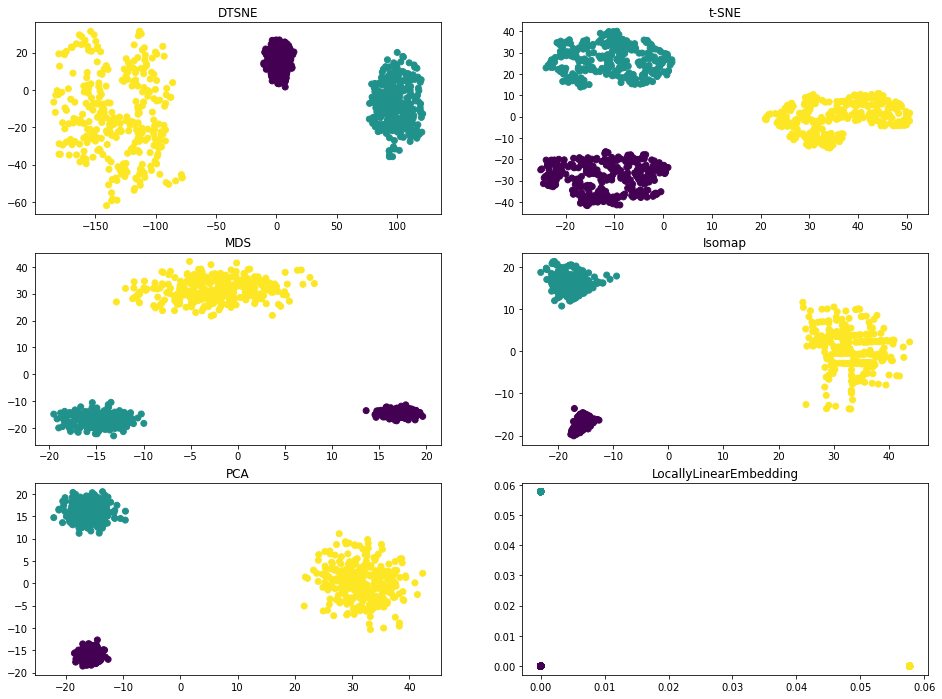

  0%|          | 0/6 [00:00<?, ?it/s]

2D_2


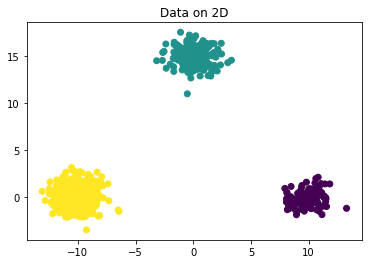

2D_2


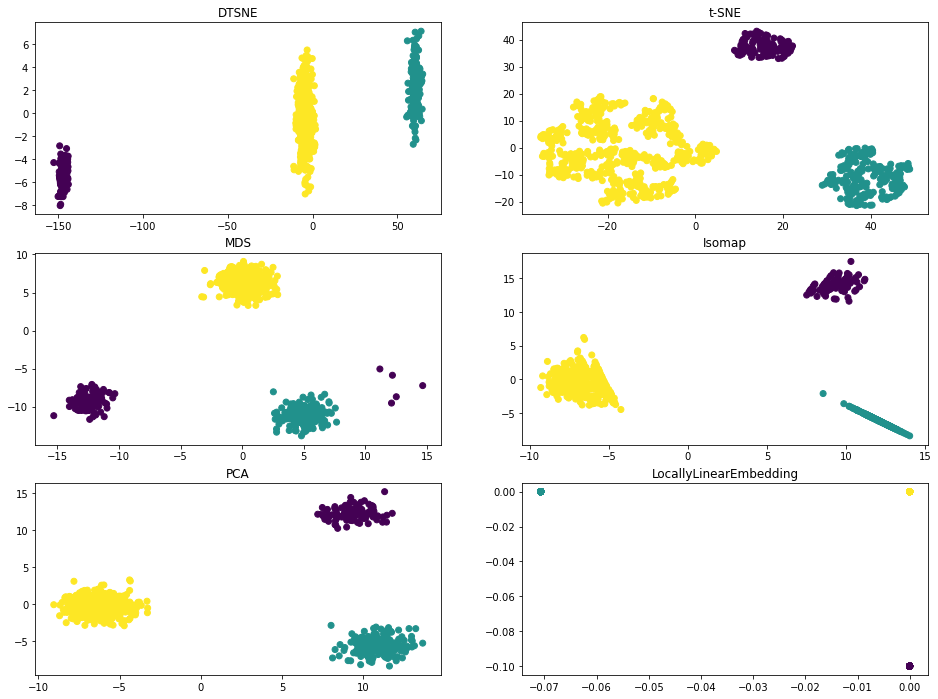

  0%|          | 0/6 [00:00<?, ?it/s]

G3-S


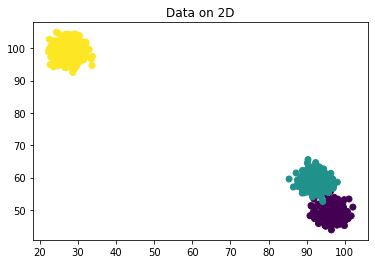

G3-S


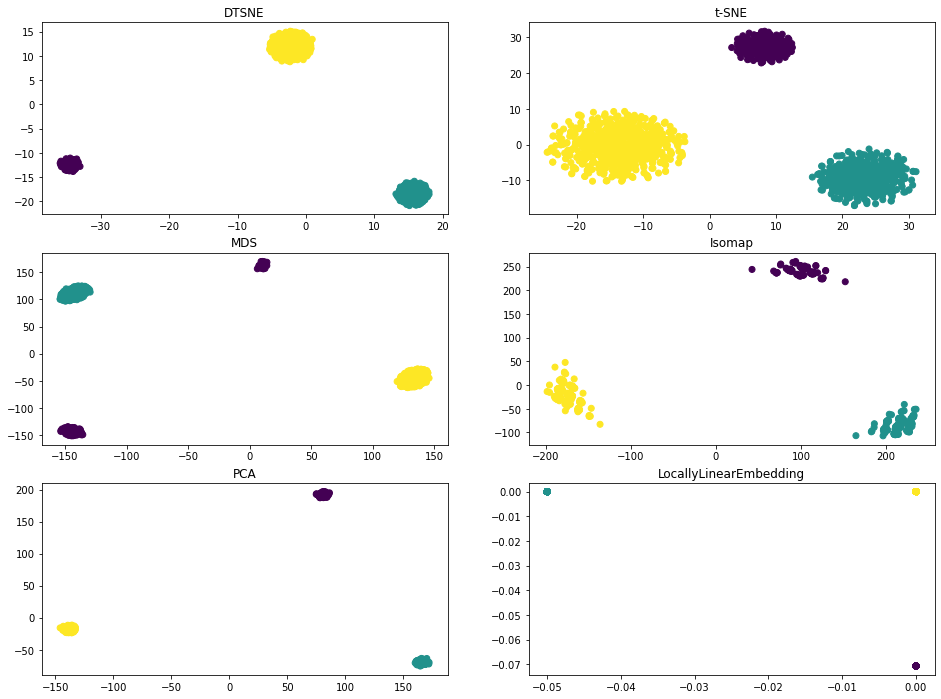

  0%|          | 0/6 [00:00<?, ?it/s]

G3-D


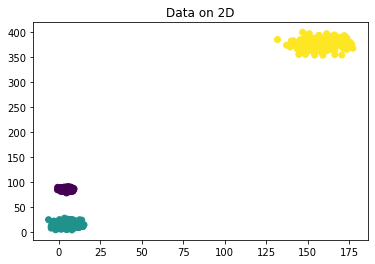

G3-D


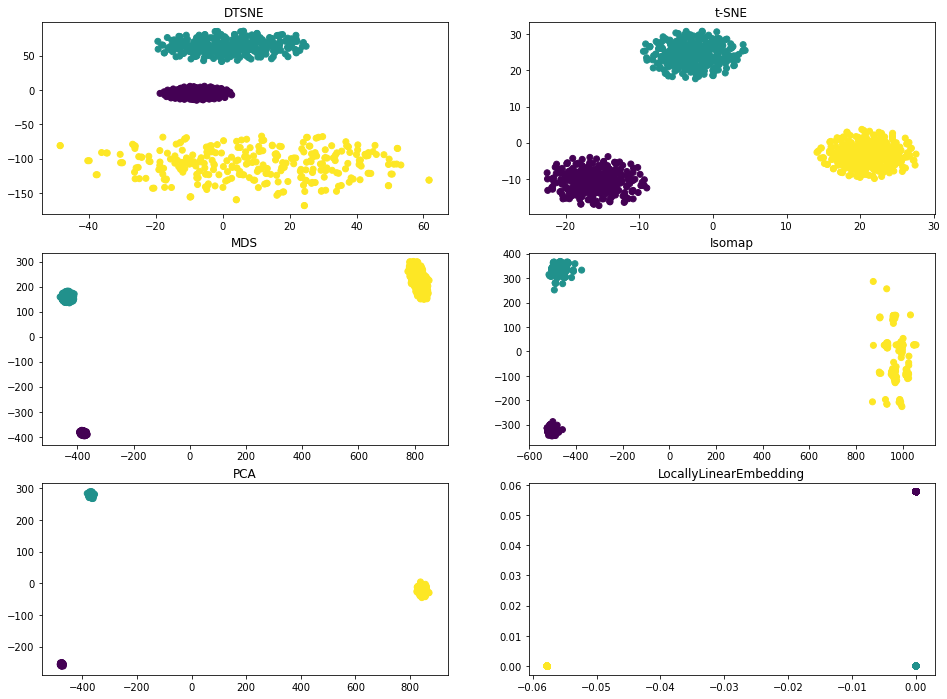

  0%|          | 0/6 [00:00<?, ?it/s]

G10-D


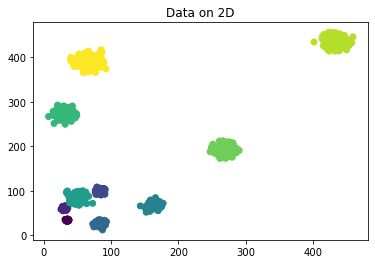

G10-D


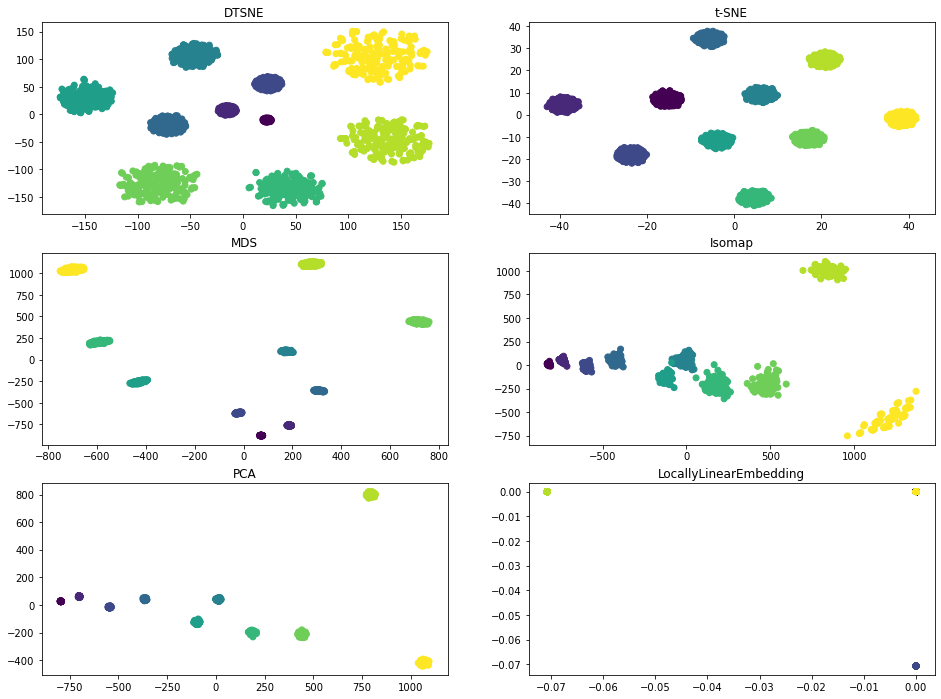

  0%|          | 0/6 [00:00<?, ?it/s]

U5-D


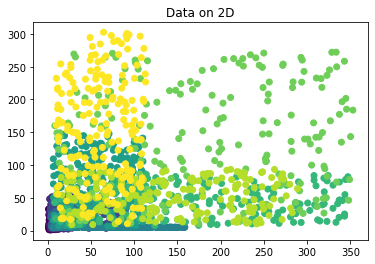

U5-D


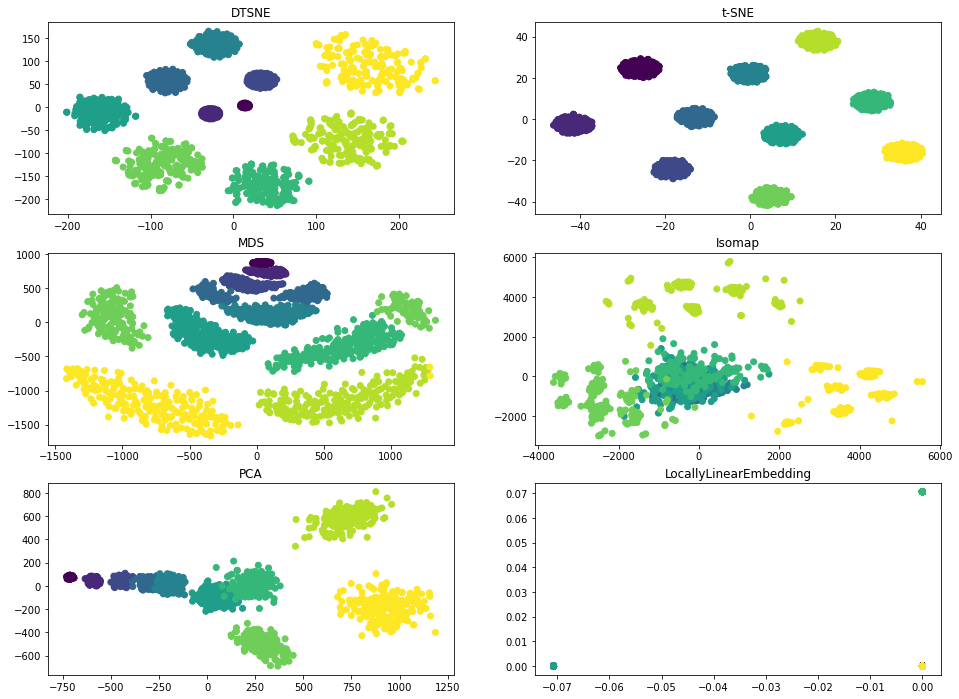

In [11]:
data = get_dtsne_datasets()
models = OrderedDict(zip(["DTSNE", "t-SNE", "MDS", "Isomap", "PCA", "LocallyLinearEmbedding"],
                         [DTSNE, TSNE, MDS, Isomap, PCA, LocallyLinearEmbedding]))

m_to_params = {
    "DTSNE": {"perplexity": 100, "n_jobs": -1, "verbose": 0, "random_state": 42},
    "t-SNE": {"n_jobs": -1, "random_state": 42},
    "MDS": {"n_jobs": -1, "max_iter": 1000, "random_state": 42},
    "Isomap": {"n_jobs": -1},
    "PCA": {"n_components": 2},
    "LocallyLinearEmbedding": {"n_jobs": -1, "random_state": 42, "max_iter": 1000},
}

metrics = {
    "global corr": global_spearman_rank,
    "local corr": local_reconstruction_correlation,
    "relative reconstruction": relative_density_reconstruction
}

res = pd.DataFrame()

for data_name, (X, labels) in data.items():
    # if data_name != "G3-S":
    #     continue
    
    X_trs = OrderedDict()
    for model_name, model_class in tqdm(models.items()):
        model = model_class(**m_to_params[model_name])
        X_tr = model.fit_transform(X)
        X_trs[model_name] = X_tr
        
        i = len(res)
        for metr_name, metric in metrics.items():
            res.loc[i, metr_name] = metric(X, X_tr)
        res.loc[i, "model"] = model_name
        res.loc[i, "dataset"] = data_name
        
    
    print(data_name)
    
    fig, axs = plt.subplots(figsize=(6, 4))
    axs.scatter(X[:, 0], X[:, 1], c=labels)
    axs.set_title("Data on 2D")
    plt.show()    
    
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    axs = np.array(axs).flatten()
    
    for i, (model_name, X_tr) in enumerate(X_trs.items()):
        axs[i].scatter(X_tr[:, 0], X_tr[:, 1], c=labels)
        axs[i].set_title(model_name)
        # axs[i].set_xtic("off")
    
    print(data_name)
    plt.show()

In [2]:
# res.to_csv("./output/dtsne_metrics.csv", index=False)
res = pd.read_csv("./output/dtsne_metrics.csv")

In [9]:
pd.set_option("display.precision", 3)

def negative_bold(val):
    bold = ['font-weight: bold' if v == val.max() else '' for v in val]
    return bold

for dt in data.keys():
    print(dt)
    t = res[res.dataset == dt].drop("dataset", axis=1)
    t.set_index("model", inplace=True)
    # t = ((t * 1000_000) // 1000) / 1000
    t.rename({"relative reconstruction": "rel reconstr"}, axis=1, inplace=True)
    display(t.style.set_precision(precision=3).apply(negative_bold, axis=0))

2D_1


,global corr,local corr,rel reconstr
model,,,
DTSNE,0.860,0.988,0.991
t-SNE,0.649,0.579,0.403
MDS,1.000,1.000,1.000
Isomap,0.991,0.980,0.983
PCA,1.000,1.000,1.000
LocallyLinearEmbedding,0.793,0.559,0.477


2D_2


,global corr,local corr,rel reconstr
model,,,
DTSNE,0.920,0.910,0.913
t-SNE,0.898,0.687,0.693
MDS,0.991,0.997,1.000
Isomap,0.969,0.798,0.749
PCA,1.000,1.000,1.000
LocallyLinearEmbedding,0.804,0.664,0.657


G3-S


,global corr,local corr,rel reconstr
model,,,
DTSNE,0.573,0.680,0.414
t-SNE,0.730,0.612,0.283
MDS,0.915,0.718,0.710
Isomap,0.857,0.394,0.200
PCA,0.953,0.600,0.426
LocallyLinearEmbedding,0.535,0.322,0.207


G3-D


,global corr,local corr,rel reconstr
model,,,
DTSNE,0.807,0.880,0.929
t-SNE,0.683,0.246,0.153
MDS,0.988,0.885,0.949
Isomap,0.921,0.554,0.768
PCA,0.989,0.813,0.866
LocallyLinearEmbedding,0.870,0.062,-0.119


G10-D


,global corr,local corr,rel reconstr
model,,,
DTSNE,0.602,0.856,0.955
t-SNE,0.605,0.133,0.099
MDS,0.944,0.824,0.933
Isomap,0.957,0.659,0.864
PCA,0.954,0.799,0.913
LocallyLinearEmbedding,0.259,-0.184,-0.300


U5-D


,global corr,local corr,rel reconstr
model,,,
DTSNE,0.590,0.855,0.957
t-SNE,0.530,0.101,0.038
MDS,0.876,0.825,0.956
Isomap,0.868,0.731,0.885
PCA,0.868,0.832,0.937
LocallyLinearEmbedding,-0.078,0.128,0.068
